# Linear Regression
Haytham Mohamed

INFS 890 - Spring 2020

In [1104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [1105]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'



test_split = 0.1

In [1106]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [1107]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

front-end_cpu_use  orders_cpu_use  orders-db_cpu_use  user_cpu_use  \
0             0.0700          0.0200             0.0100        0.0200   
1             0.0600          0.0300             0.0100        0.0200   
2             0.0600          0.0300             0.0100        0.0200   
3             0.0900          0.0300             0.0100        0.0200   
4             0.1100          0.0400             0.0100        0.0300   

   user-db_cpu_use  shipping_cpu_use  payment_cpu_use  carts_cpu_use  \
0           0.0200            0.0100           0.0100         0.1200   
1           0.0200            0.0100           0.0100         0.1400   
2           0.0200            0.0100           0.0100         0.1500   
3           0.0200            0.0100           0.0100         0.0600   
4           0.0300            0.0100           0.0100         0.1100   

   carts-db_cpu_use  front-end_pods  orders_pods  user_pods  shipping_pods  \
0            0.1600          1.0000       1.0000     1.0000         1.0000   
1            0.1700          1.0000       1.0000     1.0000         1.0000   
2            0.1400          1.0000       1.0000     1.0000         1.0000   
3            0.1900          1.0000       1.0000     1.0000         1.0000   
4            0.3200          1.0000       1.0000     1.0000         1.0000   

   payment_pods  carts_pods  nodes_cpu_use  orders_req  orders_ltcy  
0        1.0000      1.0000         1.1800      0.4000       0.6325  
1        1.0000      1.0000         1.1800      0.4400       0.6245  
2        1.0000      1.0000         1.1500      0.3600       0.6164  
3        1.0000      1.0000         1.5400      0.4000       0.5568  
4        1.0000      1.0000         2.3500      0.7800       0.5292

In [1108]:
data.shape

(1499, 18)

In [1109]:
targets = data['orders_ltcy']

inputs = data.drop(['orders_ltcy'], axis=1)
#inputs = inputs.drop(['date'], axis=1)

n_features = inputs.values.shape[1]

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))

there are 17 features


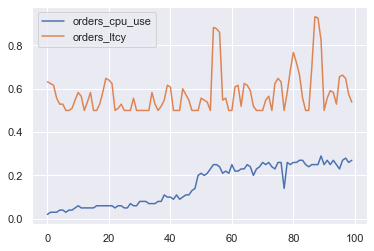

In [1110]:
#plt.scatter(data['orders_cpu_use'], data['orders_ltcy'])
#plt.xlabel('orders_cpu_use', size=18)
#plt.ylabel("orders_ltcy", size=18)
#plt.show()

# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][:100], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][:100], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Model

In [1111]:
# start:  search grid

reg = LinearRegression(normalize=True) # normalize false bacause we are going to use the scaler

# standardize the features
scaler = StandardScaler()
#scaler.fit(x_train.values.reshape(-1,n_features))

#model = LassoCV(fit_intercept=False,n_jobs=-1,random_state=0,selection='random',positive=False,cv=10)
model = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)
sfm = SelectFromModel(model)


pipe = Pipeline(steps=[
    ('selector', sfm),
    ('scaler', scaler), 
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=True)

param_grid = {
    #'selector__threshold': [0.1, 0.05, 0.02, 0.001]  # with lasso
    'selector__threshold': ['1*mean', '0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean', '0.001*mean'] # with tree
    , 'reg__normalize': [False, True]
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1)

#scores = cross_val_score(pipe, x_train, y_train, cv=kfold, n_jobs=-1
        #, verbose=3, scoring='neg_mean_squared_error')



In [1112]:
import sklearn 
print(sklearn.__version__)

search.fit(x_train, y_train)

0.22.2.post1
Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   10.2s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                                                                                        max_leaf_nodes=None,
                                                                                        max_samples=None,
                                                                  

# Best Model

In [1113]:
estimator = search.best_estimator_

score = search.best_score_
print("Best CV test score = %0.4f:" % score)

params = search.best_params_
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")

print('mean train scores')
print(all_training_scores['mean_train_score'])

print('mean test scores')
print(all_training_scores['mean_test_score'])


Best CV test score = -0.0218:
Best CV params = {'reg__normalize': False, 'selector__threshold': '0.02*mean'}

mean train scores
[-0.02986635 -0.02681844 -0.02348726 -0.02330161 -0.02282947 -0.02198088
 -0.02145361 -0.02122966 -0.02122966 -0.02998641 -0.02415352 -0.02348035
 -0.02330161 -0.02275626 -0.02223796 -0.02127823 -0.02122966 -0.02122966]
mean test scores
[-0.03004082 -0.02725586 -0.02400475 -0.02385751 -0.0232363  -0.02266957
 -0.02183598 -0.02195948 -0.02195948 -0.03036966 -0.02436229 -0.02397083
 -0.02385751 -0.0234121  -0.02288718 -0.02217781 -0.02195948 -0.02195948]


# Features Selected

In [1114]:
best_threshold = params['selector__threshold']

print('best selector threshold {}'.format(best_threshold))

#sfm = SelectFromModel(clf,threshold=best_threshold)

sfm = pipe['selector']
sfm.threshold = best_threshold

selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
print('{} features selected'.format(selectedFeatures[1].shape[0]))

feature_list = x_train.columns[sfm.get_support()]
features = ''
features = ', '.join(feature_list)
#features

reduced_x_train = x_train[feature_list]
#reduced_x_train.head(2)
print('')
for feature in reduced_x_train.columns.values:
    print(feature)

best selector threshold 0.02*mean
15 features selected

front-end_cpu_use
orders_cpu_use
orders-db_cpu_use
user_cpu_use
user-db_cpu_use
shipping_cpu_use
payment_cpu_use
carts_cpu_use
carts-db_cpu_use
front-end_pods
orders_pods
user_pods
payment_pods
nodes_cpu_use
orders_req


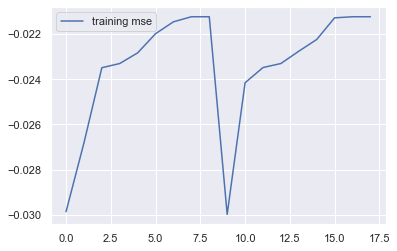

In [1115]:
pdf = pd.DataFrame(all_training_scores['mean_train_score'], columns=['training mse'])
pdf.plot()

# Training R2

In [1116]:
y_hat = estimator.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))

#print("score ", search.score(x_test, y_test))
# or also R-Squared could be obtain via
#pline.score(x_train, y_train)

R2 (training) = 0.5535815735297815


In [1117]:
print('Score (training) = {}'.format(search.score(x_train,y_train)))

Score (training) = -0.021265875533905187


In [1118]:
estimator.fit(x_train, y_train)

estimator.named_steps.reg.intercept_

0.35687400825098364

In [1119]:
estimator.named_steps.reg.coef_

array([-0.03891725,  0.00635344,  0.01073013, -0.05681167,  0.12754497,
       -0.05179901, -0.00172244,  0.11167618,  0.17401069,  0.70835174,
       -0.65540945, -0.00677587, -0.12062306])

In [1120]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.11 (0.10) 0.00 0.72 MSE


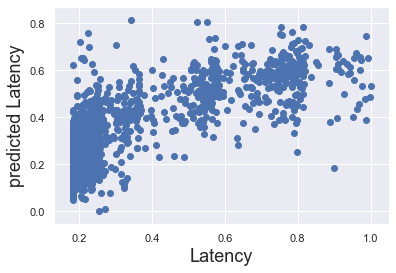

In [1121]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

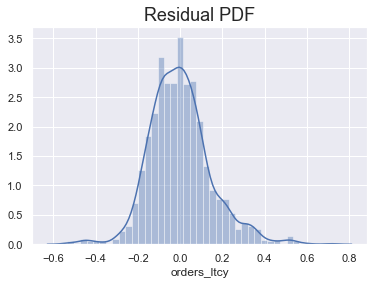

In [1122]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

# Testing

In [1123]:
y_hat_test = estimator.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

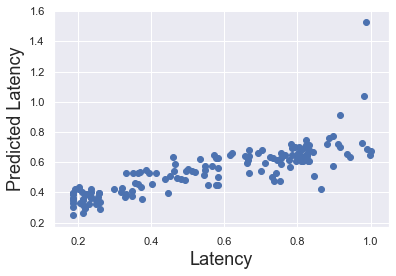

In [1124]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

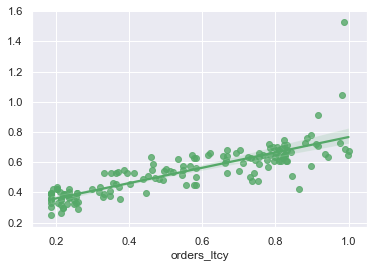

In [1125]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [1126]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

prediction  target
0      1.3879  1.2048
1      1.4700  1.2467
2      1.4346  1.2658
3      1.4224  1.2840
4      1.3769  1.2840

In [1127]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

prediction  target  residual  difference%
0        1.3879  1.2048    0.1831      15.1933
1        1.4700  1.2467    0.2234      17.9160
2        1.4346  1.2658    0.1688      13.3326
3        1.4224  1.2840    0.1383      10.7733
4        1.3769  1.2840    0.0929       7.2330
..          ...     ...       ...          ...
145      1.8789  2.1268   -0.2479      11.6573
146      1.9088  2.7126   -0.8038      29.6314
147      2.4850  2.5009   -0.0159       0.6365
148      4.6151  2.6881    1.9270      71.6871
149      2.8326  2.6692    0.1634       6.1203

[150 rows x 4 columns]

In [1128]:
perf.describe()

prediction   target  residual  difference%
count    150.0000 150.0000  150.0000     150.0000
mean       1.7331   1.7858   -0.0527      13.0893
std        0.3419   0.4596    0.3233       8.8971
min        1.2814   1.2048   -0.8498       0.0181
25%        1.4917   1.2981   -0.2668       6.3626
50%        1.7056   1.7370    0.0299      12.1385
75%        1.8997   2.2090    0.1632      17.9096
max        4.6151   2.7183    1.9270      71.6871

In [1129]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

prediction  target  residual  difference%
130        1.73    1.73      0.00         0.02
59         1.63    1.62      0.01         0.39
147        2.49    2.50     -0.02         0.64
74         1.77    1.76      0.01         0.66
123        1.62    1.64     -0.01         0.84
67         1.71    1.68      0.02         1.33
114        1.98    1.95      0.03         1.33
63         1.90    1.93     -0.03         1.47
136        1.76    1.79     -0.04         2.05
89         1.98    2.02     -0.04         2.11
36         1.43    1.46     -0.03         2.18
68         1.77    1.73      0.04         2.48
10         1.64    1.60      0.04         2.49
7          1.33    1.30      0.03         2.61
141        1.90    1.95     -0.05         2.65
105        1.91    1.85      0.05         2.80
71         1.46    1.42      0.04         2.90
62         1.72    1.67      0.05         2.97
73         1.67    1.72     -0.05         3.04
97         1.94    2.00     -0.06         3.24
33         1.44    1.39      0.05         3.90
69         1.94    1.86      0.08         4.18
58         1.71    1.64      0.07         4.19
107        1.88    1.79      0.09         4.76
109        1.85    1.94     -0.10         5.02
11         1.49    1.56     -0.08         5.03
106        1.87    1.78      0.09         5.12
56         1.63    1.55      0.08         5.26
15         1.30    1.24      0.07         5.27
57         1.74    1.65      0.09         5.34
35         1.58    1.50      0.08         5.51
50         1.66    1.57      0.09         5.78
51         1.48    1.40      0.08         6.01
149        2.83    2.67      0.16         6.12
132        1.82    1.94     -0.12         6.26
90         2.05    2.19     -0.14         6.28
72         1.54    1.45      0.09         6.34
30         1.28    1.20      0.08         6.36
12         1.51    1.42      0.09         6.38
4          1.38    1.28      0.09         7.23
120        2.11    2.28     -0.17         7.37
6          1.40    1.30      0.10         7.52
5          1.39    1.29      0.10         7.65
75         1.65    1.79     -0.14         7.67
18         1.34    1.25      0.10         7.75
17         1.34    1.25      0.10         7.81
118        1.92    1.77      0.14         8.16
49         1.72    1.59      0.13         8.41
38         1.49    1.37      0.12         8.45
87         1.89    2.06     -0.18         8.51
86         1.94    2.13     -0.18         8.69
64         2.00    2.19     -0.19         8.71
101        1.86    1.71      0.15         8.90
131        2.02    2.21     -0.20         8.91
9          1.58    1.44      0.14         9.57
85         1.88    2.08     -0.20         9.74
39         1.38    1.26      0.12         9.90
100        1.57    1.74     -0.18        10.06
70         2.04    2.28     -0.23        10.16
81         2.01    2.24     -0.23        10.23
14         1.37    1.24      0.13        10.48
3          1.42    1.28      0.14        10.77
129        1.81    2.04     -0.22        10.95
93         2.04    2.30     -0.25        10.99
80         1.91    2.15     -0.24        11.20
144        2.17    2.45     -0.28        11.34
133        2.01    2.27     -0.26        11.45
66         1.59    1.43      0.16        11.51
145        1.88    2.13     -0.25        11.66
37         1.54    1.38      0.16        11.81
34         1.69    1.51      0.18        11.92
137        2.14    2.43     -0.29        11.93
102        1.85    2.10     -0.25        11.93
119        1.98    2.25     -0.27        11.97
25         1.45    1.29      0.15        11.99
27         1.35    1.20      0.15        12.29
134        1.56    1.78     -0.22        12.30
117        1.57    1.79     -0.22        12.42
21         1.39    1.23      0.16        12.89
115        1.91    2.19     -0.28        12.92
76         1.69    1.95     -0.25        13.08
112        1.94    2.23     -0.29        13.10
79         1.80    1.59      0.21        13.24
2          1.43    1.27      0.17        13.33
8         

# *** Prediction Accuracy

In [1130]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.6222671347353055


In [1131]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.15883523984379555
